In [1]:
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from Builder import DataBuilder, Models, Process

In [2]:
# 查看python 和 pytorch 的版本
print("Python version:")
print(sys.version)
print()
print("PyTorch version:")
print(torch.__version__)

# 数据预处理
data_preprocess = DataBuilder.Preprocess("./ml-1m/ml-1m.train.rating",
                                         "./ml-1m/ml-1m.test.rating")
data_preprocess.generate_final()

Python version:
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

PyTorch version:
2.3.0a0+6ddf5cf85e.nv24.04


In [3]:
# Build Data
ratings_train = DataBuilder.RatingData('./ml-1m/ml-1m.train.rating.final')
ratings_test = DataBuilder.RatingData('./ml-1m/ml-1m.test.rating.final')
negative_dataset = DataBuilder.NegativeData('./ml-1m/ml-1m.test.negative')

In [4]:
# Create DataLoader instances for each dataset
ratings_loader_train = DataLoader(ratings_train, batch_size=256, shuffle=True)
ratings_loader_test = DataLoader(ratings_test, batch_size=256, shuffle=True)
negative_loader = DataLoader(negative_dataset, batch_size=256, shuffle=False)

In [5]:
all_users = ratings_train.ratings['user_id'].nunique()
all_items = ratings_train.ratings['item_id'].nunique()

In [20]:
num_factors = 8
mlp_layers = [64, 32, 16, 8]

models = {
    'GMF': Models.GMF(all_users, all_items, num_factors),
    'MLP-0': Models.MLP_with_hidden_layers(all_users, all_items, num_factors, 0),
    'MLP-1': Models.MLP_with_hidden_layers(all_users, all_items, num_factors, 1),
    'MLP-2': Models.MLP_with_hidden_layers(all_users, all_items, num_factors, 2),
    'MLP-3': Models.MLP_with_hidden_layers(all_users, all_items, num_factors, 3),
    'MLP-4': Models.MLP_with_hidden_layers(all_users, all_items, num_factors, 4),
    'NeuMF': Models.NeuMF(all_users, all_items, num_factors, mlp_layers)
}

In [21]:
epochs = 100
results = {name: {'train_loss': [], 'HR@10': [], 'NDCG@10': []} for name in models}

In [8]:
import json  
  
def save_results_to_txt(model_name, results, file_path):  
    # 假设results是一个嵌套的字典，如 {model_name: {'train_loss': [], 'HR@10': [], 'NDCG@10': []}}  
    with open(file_path, 'w') as f:  
        # 将results中特定模型的数据转换为易于阅读的格式  
        formatted_results = {  
            'train_loss': results[model_name]['train_loss'],  
            'HR@10': results[model_name]['HR@10'],  
            'NDCG@10': results[model_name]['NDCG@10']  
        }  
          
        # 将字典转换为JSON字符串（可选：为了可读性，你可以设置indent参数）  
        json_str = json.dumps(formatted_results, indent=2)  
          
        # 写入文件（或者，你可以直接写入格式化后的字符串，而不是JSON）  
        f.write(json_str)

In [11]:
# Training loop
for name, model in models.items():
    print(f"Training {name}")
    model = model.to(torch.device("cuda:0"))# if torch.cuda.is_available() else "cpu"
    print(model.device)
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        train_loss = Process.train(model, ratings_loader_train, optimizer, criterion)
        hr, ndcg = Process.evaluate(model, ratings_loader_test, negative_loader)
    

        # Store metrics
        results[name]['train_loss'].append(train_loss)
        results[name]['HR@10'].append(hr)
        results[name]['NDCG@10'].append(ndcg)

        # Optionally print the metrics
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, HR@10: {hr:.4f}, NDCG@10: {ndcg:.4f}')
    save_results_to_txt(name, results, f'./{name}.json')

Training NeuMF
cuda
Epoch 1/100, Train Loss: 0.3945, HR@10: 0.3568, NDCG@10: 0.5778
Epoch 2/100, Train Loss: 0.3610, HR@10: 0.3705, NDCG@10: 0.5689
Epoch 3/100, Train Loss: 0.3598, HR@10: 0.3797, NDCG@10: 0.5525
Epoch 4/100, Train Loss: 0.3597, HR@10: 0.4083, NDCG@10: 0.5085
Epoch 5/100, Train Loss: 0.3596, HR@10: 0.4659, NDCG@10: 0.4500
Epoch 6/100, Train Loss: 0.3596, HR@10: 0.5395, NDCG@10: 0.3972
Epoch 7/100, Train Loss: 0.3596, HR@10: 0.6043, NDCG@10: 0.3621
Epoch 8/100, Train Loss: 0.3596, HR@10: 0.6357, NDCG@10: 0.3566
Epoch 9/100, Train Loss: 0.3596, HR@10: 1.0000, NDCG@10: 0.3567
Epoch 10/100, Train Loss: 0.3596, HR@10: 1.0000, NDCG@10: 0.3563
Epoch 11/100, Train Loss: 0.3596, HR@10: 1.0000, NDCG@10: 0.3565
Epoch 12/100, Train Loss: 0.3596, HR@10: 1.0000, NDCG@10: 0.3563
Epoch 13/100, Train Loss: 0.3596, HR@10: 1.0000, NDCG@10: 0.3565
Epoch 14/100, Train Loss: 0.3596, HR@10: 1.0000, NDCG@10: 0.3563
Epoch 15/100, Train Loss: 0.3596, HR@10: 1.0000, NDCG@10: 0.3563
Epoch 16/100, 

In [12]:
import pandas as pd

In [16]:
results = {}

In [22]:
for name, model in models.items():
    df_tmp = pd.read_json(f'./output_data/{name}.json')
    results[name]['train_loss'].extend(df_tmp['train_loss'].to_list())
    results[name]['HR@10'].extend(df_tmp['HR@10'].to_list())
    results[name]['NDCG@10'].extend(df_tmp['NDCG@10'].to_list())

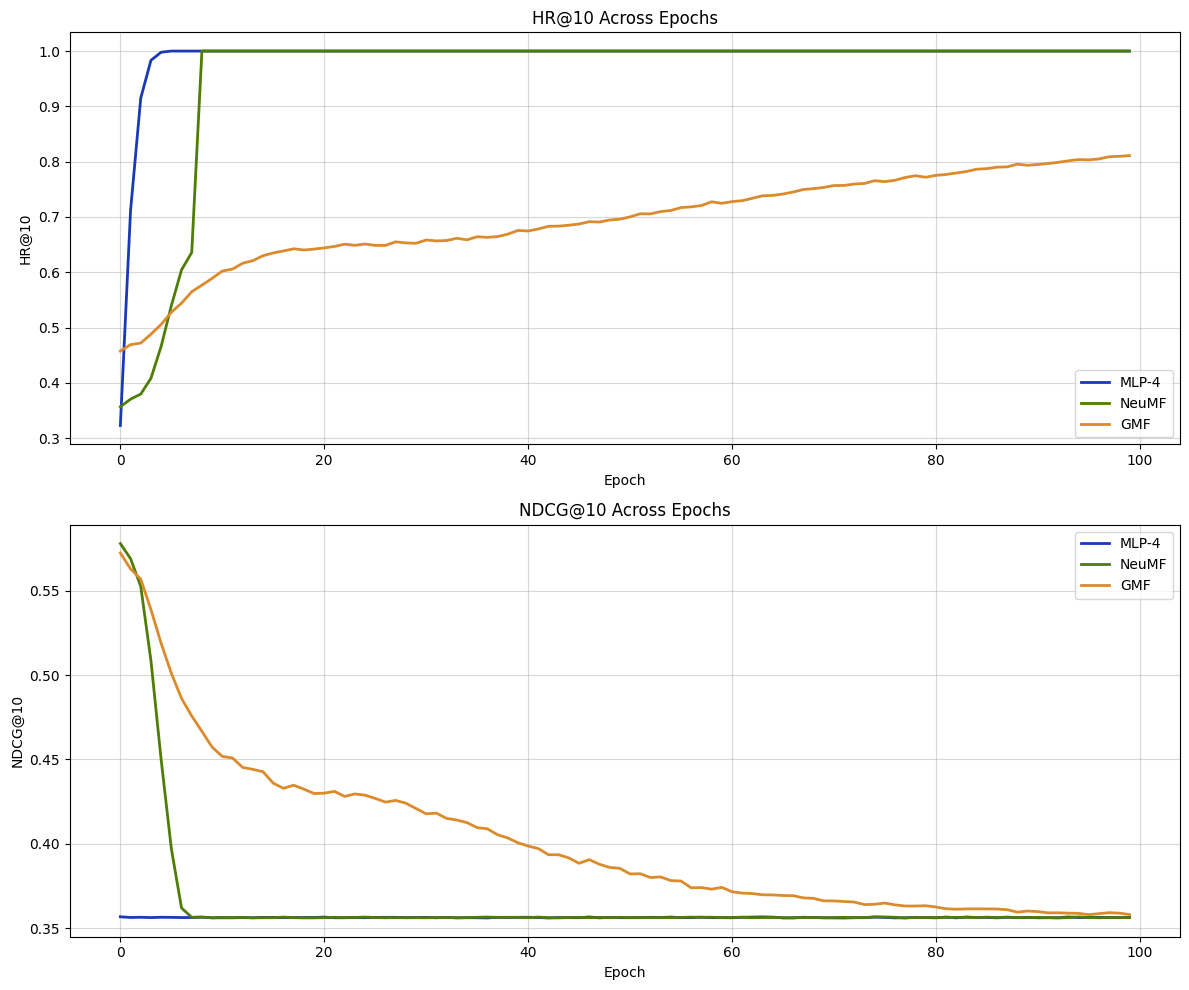

In [23]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
titles = ['HR@10 Across Epochs', 'NDCG@10 Across Epochs']
models = ['MLP-4', 'NeuMF', 'GMF']
colors = {'MLP-4': '#1939B7', 'NeuMF': '#4F7C03', 'GMF': '#DB8A2C'}
metrics = ['HR@10', 'NDCG@10']

for i, metric in enumerate(metrics):
    for model in models:
        axes[i].plot(results[model][metric], label=model, color=colors[model], linewidth=2)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(metric)
    axes[i].legend()
    axes[i].grid(True, alpha=0.5)

plt.tight_layout()
plt.savefig('./output_data/out1.png')
plt.show()

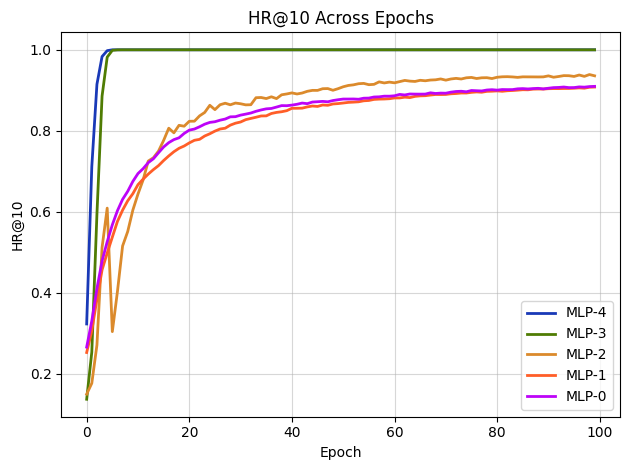

In [24]:
fig = plt.figure()
titles = ['HR@10 Across Epochs']
models = ['MLP-4','MLP-3','MLP-2','MLP-1','MLP-0']
colors = {'MLP-4': '#1939B7', 'MLP-3': '#4F7C03', 'MLP-2': '#DB8A2C', 'MLP-1': '#FF5E28', 'MLP-0': '#bd03f8'}
metrics = ['HR@10']

for i, metric in enumerate(metrics):
    for model in models:
        plt.plot(results[model][metric], label=model, color=colors[model], linewidth=2)
    plt.title(titles[i])
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.savefig('./output_data/out2.png')
plt.show()